# CARE Denoising with Synthetic Microsim Dataset 
This notebook demonstrates CARE (Content-Aware Image Restoration) denoising on synthetic microscopy data generated using Microsim. The dataset is generated using cosem, a wrapper around the Janelia OpenOrganelle dataset. This is a rich dataset of FIB-SEM images of cells, together with annotations of various organelles.
Unlike Noise2Void which uses self-supervised learning, CARE is a supervised denoising method that requires paired noisy/clean training data.

## Part 1: Generating Synthetic Data with Microsim
We'll use the Janelia COSEM dataset to create realistic cellular structures. The COSEM dataset contains segmented organelles from electron microscopy data.

In [1]:
import numpy as np
import warnings
from typing import Annotated, Any, Literal
from annotated_types import Ge
import matplotlib.pyplot as plt
from pathlib import Path
from tifffile import imread
from careamics import CAREamist
from careamics.config import create_care_configuration
from careamics.utils.metrics import scale_invariant_psnr
from careamics.utils import autocorrelation
from microssim import micro_structural_similarity
from microsim import schema as ms
from microsim.util import ortho_plot
from microsim.cosem import CosemDataset
from microsim.schema.optical_config import lib
from skimage.transform import downscale_local_mean

/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First we must create the microsim ground truth which returns the position and quantity of fluorophores in the sample.

[10:11:02:647029] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=469641;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=598570;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[10:11:13:235744] INFO     Ground truth generated in 10.58 seconds                                ]8;id=953882;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=201836;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

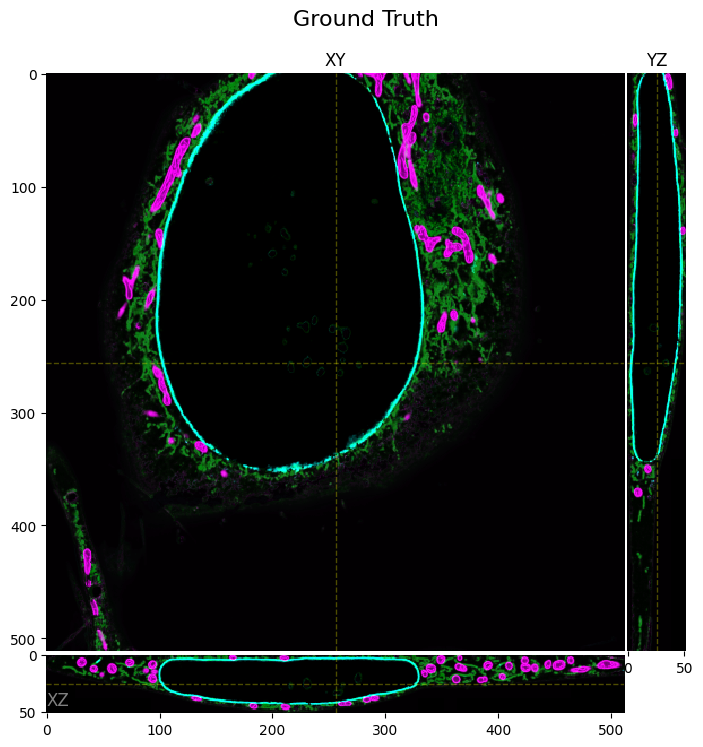

In [2]:
sim = ms.Simulation(
    truth_space=ms.ShapeScaleSpace(shape=(52, 512, 512), scale=(0.064, 0.064, 0.064)),
    output_space={"downscale": 2},
    sample=ms.Sample(
        labels=[
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="ne_pred"), 
                fluorophore="mTagBFP2",
            ),
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="er-mem_pred"),
                fluorophore="EGFP",
            ),
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="mito-mem_pred"),
                fluorophore="mScarlet",
            ),
        ]
    ),
    channels=[lib.DAPI, lib.FITC, lib.DSRED],
    modality=ms.Confocal(pinhole_au=2),
    detector=ms.CameraCCD(qe=0.82, read_noise=1),
    output_path="h2-cf.tif",
    settings=ms.Settings(max_psf_radius_aus=2),
)

ground_truth = sim.ground_truth()  # ground truth for microsim
ortho_plot(ground_truth, title="Ground Truth", cmap=["cyan", "green", "magenta"])

We use the microsim ground truth to create a biologically realistic ground truth using the optical_image function, which convolves the scaled fluorophore distributions with the optical point spread function (PSF) of the microscope to form the (noise free) optical image.

[10:11:13:573581] INFO     Creating optical_image ...                                             ]8;id=614272;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=228026;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[10:11:13:575890] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=183057;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=330988;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[10:11:13:577726] INFO     Ground truth generated in 0.00 seconds                                 ]8;id=933908;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=255912;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[10:11:13:704577] INFO     Rendering Confocal channel DAPI ---------------                        ]8;id=428858;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=200787;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[10:11:13:706675] INFO       Fluor: mTagBFP2                                                      ]8;id=600046;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=370043;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:11:13:904456] INFO         Need PSF (52,513) @ 461.1 nm (weight=19.84)                       ]8;id=79785;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=295764;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[10:11:13:911474] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.46            ]8;id=863192;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=866961;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[10:11:15:808799] INFO       Fluor: EGFP                                                          ]8;id=626649;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=711097;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:11:15:856272] INFO         Need PSF (52,513) @ 479.9 nm (weight=0.14)                        ]8;id=96847;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=290921;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[10:11:15:859852] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.48            ]8;id=820100;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=653784;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[10:11:17:770907] INFO       Fluor: mScarlet                                                      ]8;id=229620;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=965079;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:11:17:834499] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=422288;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=318131;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[10:11:17:837396] INFO       Fluor: mTagBFP2                                                      ]8;id=454593;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=879143;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:11:17:885064] INFO         Need PSF (52,513) @ 518.0 nm (weight=0.01)                        ]8;id=536234;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=715114;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[10:11:17:888795] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=921853;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=301196;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[10:11:19:797807] INFO       Fluor: EGFP                                                          ]8;id=701045;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=921860;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:11:19:843290] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=986007;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=481125;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[10:11:19:846882] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=460954;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=362373;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[10:11:21:761962] INFO       Fluor: mScarlet                                                      ]8;id=633081;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=619369;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:11:21:808182] INFO         Need PSF (52,513) @ 546.5 nm (weight=0.04)                        ]8;id=366562;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=166147;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[10:11:21:812699] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.55            ]8;id=334868;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=778677;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[10:11:23:732988] INFO     Rendering Confocal channel DSRED ---------------                       ]8;id=940243;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=81622;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[10:11:23:735905] INFO       Fluor: mTagBFP2                                                      ]8;id=513835;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=429956;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:11:23:802744] INFO       Fluor: EGFP                                                          ]8;id=678561;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=597710;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:11:23:868242] INFO         Need PSF (52,513) @ 610.9 nm (weight=0.05)                        ]8;id=904841;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=36382;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[10:11:23:871433] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.61            ]8;id=358204;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=454713;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[10:11:25:771717] INFO       Fluor: mScarlet                                                      ]8;id=277468;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=638429;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:11:25:837523] INFO         Need PSF (52,513) @ 615.8 nm (weight=194.40)                      ]8;id=989598;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=351059;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[10:11:25:841193] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.62            ]8;id=597064;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=937552;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

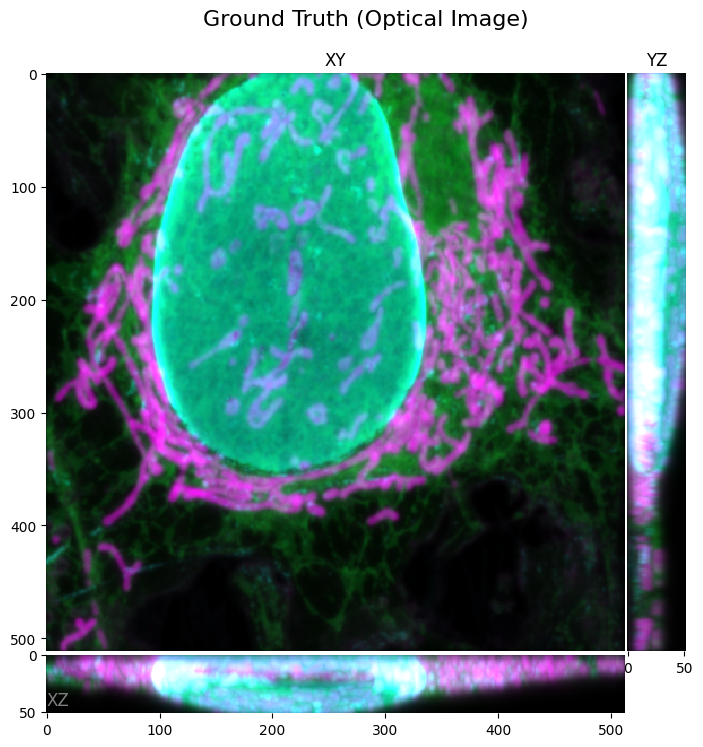

In [3]:
optical_image_gt = sim.optical_image()  # this is the clean ground truth we use for CARE
ortho_plot(optical_image_gt, title="Ground Truth (Optical Image)", 
          cmap=["cyan", "green", "magenta"], mip=True)

Next we generate the noisy_image for CARE. This is done by simulating the final stage of image acquisition with the digital_image function. This function takes the noise-free optical_image and applies realistic detector effects. 

Generating noisy training data...


[10:16:22:795579] INFO     Creating optical_image ...                                             ]8;id=724867;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=980597;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[10:16:22:798669] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=674237;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=211178;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[10:16:22:800586] INFO     Ground truth generated in 0.00 seconds                                 ]8;id=289690;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=317410;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[10:16:22:925058] INFO     Rendering Confocal channel DAPI ---------------                        ]8;id=952609;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=755196;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[10:16:22:927072] INFO       Fluor: mTagBFP2                                                      ]8;id=475658;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=280455;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:16:23:075811] INFO         Need PSF (52,513) @ 461.1 nm (weight=19.84)                       ]8;id=444755;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=217244;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[10:16:24:965255] INFO       Fluor: EGFP                                                          ]8;id=207042;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=869572;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:16:25:010290] INFO         Need PSF (52,513) @ 479.9 nm (weight=0.14)                        ]8;id=543518;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=523888;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[10:16:26:899963] INFO       Fluor: mScarlet                                                      ]8;id=767637;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=661534;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:16:26:964351] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=557289;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=707437;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[10:16:26:967194] INFO       Fluor: mTagBFP2                                                      ]8;id=675334;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=976917;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:16:27:016258] INFO         Need PSF (52,513) @ 518.0 nm (weight=0.01)                        ]8;id=837331;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=915948;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[10:16:28:908305] INFO       Fluor: EGFP                                                          ]8;id=755425;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=234127;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:16:28:955060] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=714018;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=891807;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[10:16:30:849290] INFO       Fluor: mScarlet                                                      ]8;id=54;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=757796;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:16:30:894791] INFO         Need PSF (52,513) @ 546.5 nm (weight=0.04)                        ]8;id=955303;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=557071;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[10:16:32:802321] INFO     Rendering Confocal channel DSRED ---------------                       ]8;id=179922;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=838522;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[10:16:32:805307] INFO       Fluor: mTagBFP2                                                      ]8;id=934604;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=202351;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:16:32:872348] INFO       Fluor: EGFP                                                          ]8;id=794896;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=874537;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:16:32:940326] INFO         Need PSF (52,513) @ 610.9 nm (weight=0.05)                        ]8;id=306083;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=471797;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[10:16:34:847301] INFO       Fluor: mScarlet                                                      ]8;id=461964;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=734753;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[10:16:34:913874] INFO         Need PSF (52,513) @ 615.8 nm (weight=194.40)                      ]8;id=766334;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=534787;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

Generating noisy image 1/4 with params: {'exposure_ms': 5, 'read_noise': 15, 'gain': 3.0}


[10:16:37:173766] INFO     Creating digital_image ...                                             ]8;id=844813;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=234389;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[10:16:37:176125] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=321688;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=25631;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[10:16:37:665885] INFO     Simulating CameraCCD detector ...                                      ]8;id=152724;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=925117;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[10:16:38:417248] INFO     Digital image generated in 1.24 seconds                                ]8;id=482793;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=798663;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

Generating noisy image 2/4 with params: {'exposure_ms': 8, 'read_noise': 12, 'gain': 2.5}


[10:16:38:424874] INFO     Creating digital_image ...                                             ]8;id=552672;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=98659;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[10:16:38:426934] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=198524;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=688978;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[10:16:38:914433] INFO     Simulating CameraCCD detector ...                                      ]8;id=538318;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=181925;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[10:16:39:688995] INFO     Digital image generated in 1.26 seconds                                ]8;id=977367;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=454352;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

Generating noisy image 3/4 with params: {'exposure_ms': 3, 'read_noise': 18, 'gain': 3.5}


[10:16:39:696950] INFO     Creating digital_image ...                                             ]8;id=437164;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=817816;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[10:16:39:699069] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=249411;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=800444;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[10:16:40:183295] INFO     Simulating CameraCCD detector ...                                      ]8;id=586663;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=634228;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[10:16:40:903598] INFO     Digital image generated in 1.21 seconds                                ]8;id=266847;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=555703;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

Generating noisy image 4/4 with params: {'exposure_ms': 6, 'read_noise': 10, 'gain': 2.0}


[10:16:40:911427] INFO     Creating digital_image ...                                             ]8;id=23475;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=546371;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[10:16:40:913594] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=774077;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=639572;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[10:16:41:407057] INFO     Simulating CameraCCD detector ...                                      ]8;id=539754;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=256306;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[10:16:42:165313] INFO     Digital image generated in 1.25 seconds                                ]8;id=262334;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=356706;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

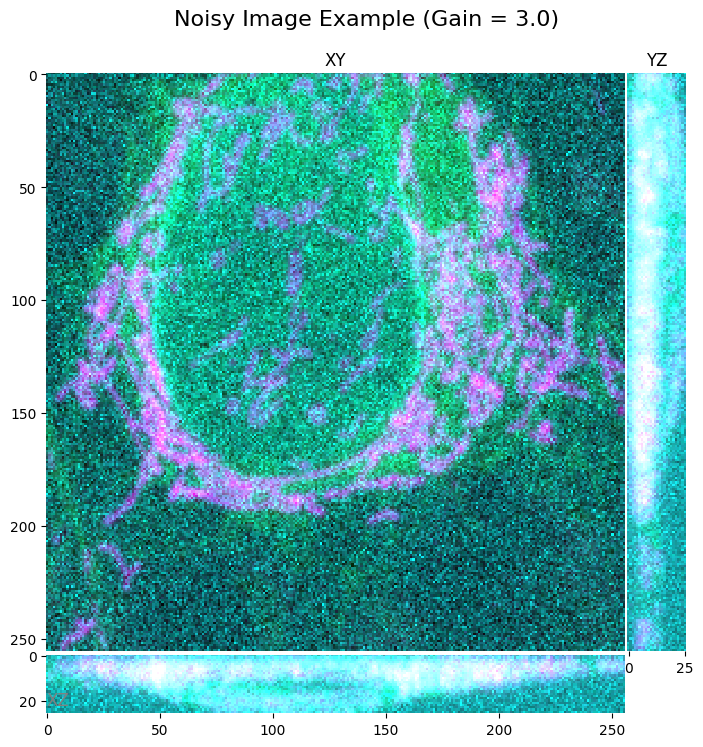

In [11]:
def generate_noisy_image(sim, optical_image, exposure_ms=5, read_noise=15, gain=3.0):
    """Generate a noisy version of the optical image with specified noise parameters."""
    # Update simulation parameters for noise generation
    sim_noisy = ms.Simulation(
        truth_space=ms.ShapeScaleSpace(shape=(52, 512, 512), scale=(0.064, 0.064, 0.064)),
        output_space={"downscale": 2},
        sample=ms.Sample(
            labels=[
                ms.FluorophoreDistribution(
                    distribution=ms.CosemLabel(dataset="jrc_hela-3", label="ne_pred"),
                    fluorophore="mTagBFP2",
                    concentration=0.7
                ),
                ms.FluorophoreDistribution(
                    distribution=ms.CosemLabel(dataset="jrc_hela-3", label="er-mem_pred"),
                    fluorophore="EGFP",
                    concentration=0.7 
                ),
                ms.FluorophoreDistribution(
                    distribution=ms.CosemLabel(dataset="jrc_hela-3", label="mito-mem_pred"),
                    fluorophore="mScarlet",
                    concentration=0.7
                ),
            ]
        ),
        channels=[lib.DAPI, lib.FITC, lib.DSRED],
        modality=ms.Confocal(pinhole_au=2),
        detector=ms.CameraCCD(qe=0.82, read_noise=read_noise, gain=gain),
        settings=ms.Settings(max_psf_radius_aus=2),
    )
    
    return sim_noisy.digital_image(optical_image, exposure_ms=exposure_ms)

# Generate multiple noisy versions for robust training
noisy_images = []
noise_levels = [
    {"exposure_ms": 5, "read_noise": 15, "gain": 3.0},
    {"exposure_ms": 8, "read_noise": 12, "gain": 2.5},
    {"exposure_ms": 3, "read_noise": 18, "gain": 3.5},
    {"exposure_ms": 6, "read_noise": 10, "gain": 2.0},
]

print("Generating noisy training data...")
ground_truth_optical = sim.optical_image()

for i, params in enumerate(noise_levels):
    print(f"Generating noisy image {i+1}/{len(noise_levels)} with params: {params}")
    noisy_img = generate_noisy_image(sim, ground_truth_optical, **params)
    noisy_images.append(noisy_img)

# Display one example
ortho_plot(noisy_images[0], title="Noisy Image Example (Gain = 3.0)", 
          cmap=["cyan", "green", "magenta"], mip=True)

In [13]:
# Select the best Z-slice based on the ground truth signal
signal_per_z = optical_image_gt.sum(axis=(0, 2, 3)).data
z_slice_index = np.argmax(signal_per_z)
print(f"Using Z-slice {z_slice_index} for training.")
channel_index = 1

gt_slice = optical_image_gt.data[channel_index, z_slice_index]

# Prepare training data: collect all noisy slices
noisy_slices = []
for noisy_img in noisy_images:
    downscale_factor = 2  # from sim.output_space.downscale
    z_slice_low_res_index = z_slice_index // downscale_factor
    noisy_slice = noisy_img.data[channel_index, z_slice_low_res_index]
    noisy_slices.append(noisy_slice)

# Downsample the high-resolution ground truth to match noisy slice resolution
gt_slice_low_res = downscale_local_mean(
    gt_slice,
    factors=(downscale_factor, downscale_factor)
).astype(gt_slice.dtype)

print(f"Shape of clean target slice: {gt_slice_low_res.shape}")
print(f"Shape of each noisy training slice: {noisy_slices[0].shape}")
print(f"Number of noisy training samples: {len(noisy_slices)}")

Using Z-slice 10 for training.
Shape of clean target slice: (256, 256)
Shape of each noisy training slice: (256, 256)
Number of noisy training samples: 4


## Part 2: CARE denoising with CAREamics

Now that we have generated our microsim data, we'll train a Noise2Void model to denoise our images.

In [18]:
# Create a configuration for a CARE model
config = create_care_configuration(
    experiment_name="microsim_care",
    data_type="array",
    axes="YX",
    patch_size=[64, 64],
    batch_size=16,
    num_epochs=50,
)

# Initialize CAREamist with the configuration
careamist = CAREamist(source=config)

# Train on each noisy image separately (Option 2)
print(f"Training on {len(noisy_slices)} noisy samples individually...")

for i, noisy_slice in enumerate(noisy_slices):
    print(f"\nTraining on noisy sample {i+1}/{len(noisy_slices)}")
    print(f"Noisy slice shape: {noisy_slice.shape}")
    print(f"Clean target shape: {gt_slice_low_res.shape}")
    
    careamist.train(
        train_source=noisy_slice,        # Single noisy image (256, 256)
        train_target=gt_slice_low_res,   # Single clean target (256, 256)
        val_percentage=0.2,           
    )

No working directory provided. Using current working directory: /home/diya.srivastava/Desktop/repos/careamics-examples/applications/care/denoising/2D.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Extracted 16 patches from input array.
Computed dataset mean: [139.46424866], std: [31.44990364]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 509 K  | train
---------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Training on 4 noisy samples individually...

Training on noisy sample 1/4
Noisy slice shape: (256, 256)
Clean target shape: (256, 256)
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s, train_loss_step=0.121, val_loss=0.116, train_loss_epoch=0.121]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, train_loss_step=0.121, val_loss=0.116, train_loss_epoch=0.121]

Training on noisy sample 2/4
Noisy slice shape: (256, 256)
Clean target shape: (256, 256)


Extracted 16 patches from input array.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 509 K  | train
---------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


`Trainer.fit` stopped: `max_epochs=50` reached.
Extracted 16 patches from input array.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 509 K  | train
---------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode



Training on noisy sample 3/4
Noisy slice shape: (256, 256)
Clean target shape: (256, 256)


`Trainer.fit` stopped: `max_epochs=50` reached.
Extracted 16 patches from input array.



Training on noisy sample 4/4
Noisy slice shape: (256, 256)
Clean target shape: (256, 256)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 509 K  | train
---------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


`Trainer.fit` stopped: `max_epochs=50` reached.


## Predict using the trained model

In [19]:
test_noisy_slice = noisy_slices[0]
test_clean_slice = gt_slice_low_res

print(f"Test noisy slice shape: {test_noisy_slice.shape}")
print(f"Test clean slice shape: {test_clean_slice.shape}")

# Make predictions using the trained CARE model
predictions = careamist.predict(
    source=test_noisy_slice,
    data_type="array",
    axes="YX",
    tile_size=(128, 128),
    tile_overlap=(64, 64),
    batch_size=1,
)

denoised_images = np.squeeze(np.array(predictions))
print(f"Denoised image shape: {denoised_images.shape}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Test noisy slice shape: (256, 256)
Test clean slice shape: (256, 256)
Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 205.85it/s]
Denoised image shape: (256, 256)


## Evaluate denoising performance and visualize the results

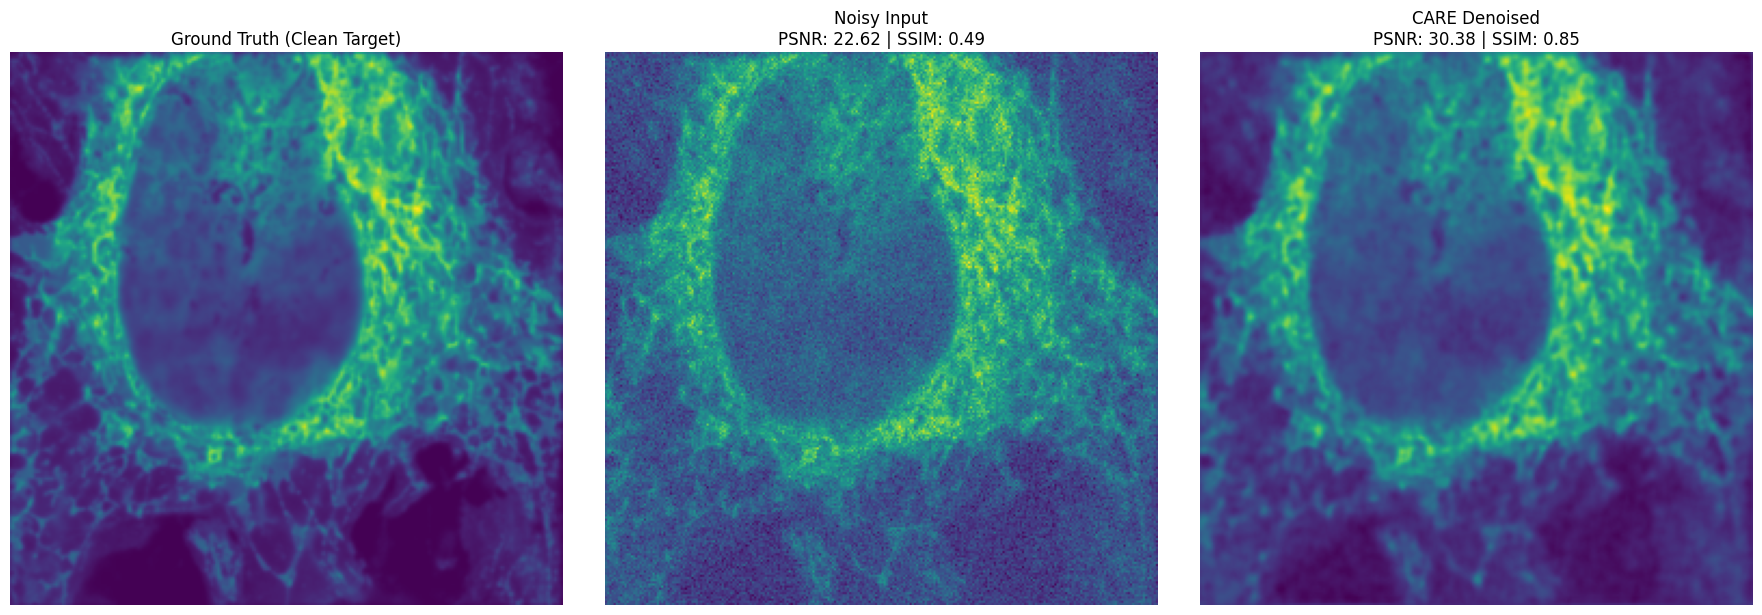


Quantitative Results:
Input PSNR: 22.62 dB, SSIM: 0.494
CARE PSNR: 30.38 dB, SSIM: 0.854
PSNR Improvement: 7.76 dB
SSIM Improvement: 0.360


In [20]:
# Normalize images to [0, 1] range 
def normalize(img):
    min_val, max_val = img.min(), img.max()
    return (img - min_val) / (max_val - min_val) if max_val > min_val else img - min_val

gt_normalized = normalize(test_clean_slice)
noisy_normalized = normalize(test_noisy_slice)
denoised_normalized = normalize(denoised_images)

# Compute metrics
psnr_noisy = scale_invariant_psnr(gt_normalized, noisy_normalized)
ssim_noisy = micro_structural_similarity(gt_normalized, noisy_normalized)
psnr_denoised = scale_invariant_psnr(gt_normalized, denoised_normalized)
ssim_denoised = micro_structural_similarity(gt_normalized, denoised_normalized)

# Visualizations
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(gt_normalized, cmap='viridis')
ax[0].set_title('Ground Truth (Clean Target)')
ax[0].axis('off')

ax[1].imshow(noisy_normalized, cmap='viridis')
ax[1].set_title(f'Noisy Input\nPSNR: {psnr_noisy:.2f} | SSIM: {ssim_noisy:.2f}')
ax[1].axis('off')

ax[2].imshow(denoised_normalized, cmap='viridis')
ax[2].set_title(f'CARE Denoised\nPSNR: {psnr_denoised:.2f} | SSIM: {ssim_denoised:.2f}')
ax[2].axis('off')

plt.tight_layout()
plt.show()

print(f"\nQuantitative Results:")
print(f"Input PSNR: {psnr_noisy:.2f} dB, SSIM: {ssim_noisy:.3f}")
print(f"CARE PSNR: {psnr_denoised:.2f} dB, SSIM: {ssim_denoised:.3f}")
print(f"PSNR Improvement: {psnr_denoised - psnr_noisy:.2f} dB")
print(f"SSIM Improvement: {ssim_denoised - ssim_noisy:.3f}")

## Plot training metrics

{'epoch': [], 'learning_rate': [], 'step': [], 'train_loss_epoch': [], 'train_loss_step': [], 'val_loss': []}


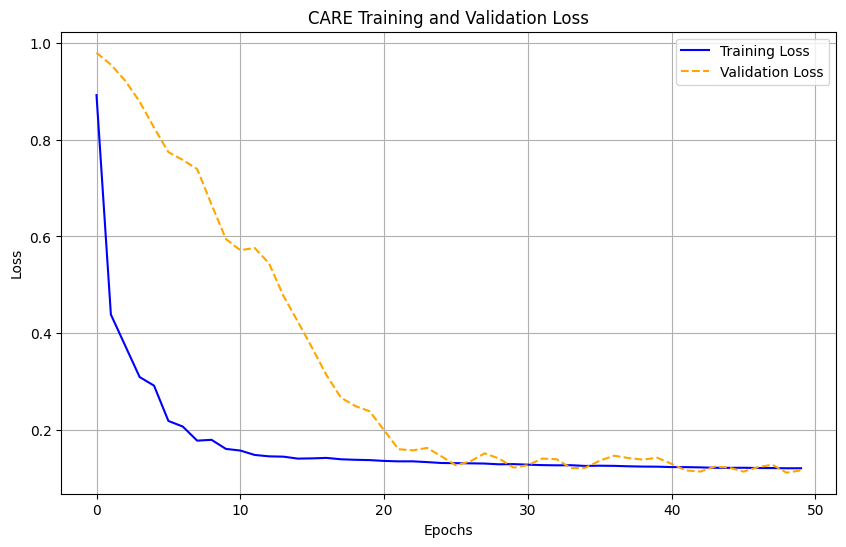

In [22]:
# Retrieve the training and validation losses
losses = careamist.get_losses()

# Extract train and validation losses
train_losses = losses.get('train_loss', [])
val_losses = losses.get('val_loss', [])
train_epochs = list(range(len(train_losses)))
val_epochs = list(range(len(val_losses)))

# Plot the losses
plt.figure(figsize=(10, 6))
if train_losses:
    plt.plot(train_epochs, train_losses, label='Training Loss', color='blue')
if val_losses:
    plt.plot(val_epochs, val_losses, label='Validation Loss', 
             linestyle='--', color='orange')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CARE Training and Validation Loss')
plt.grid(True)
plt.legend()
plt.show()

## Create a visualization for a comparison of before/after

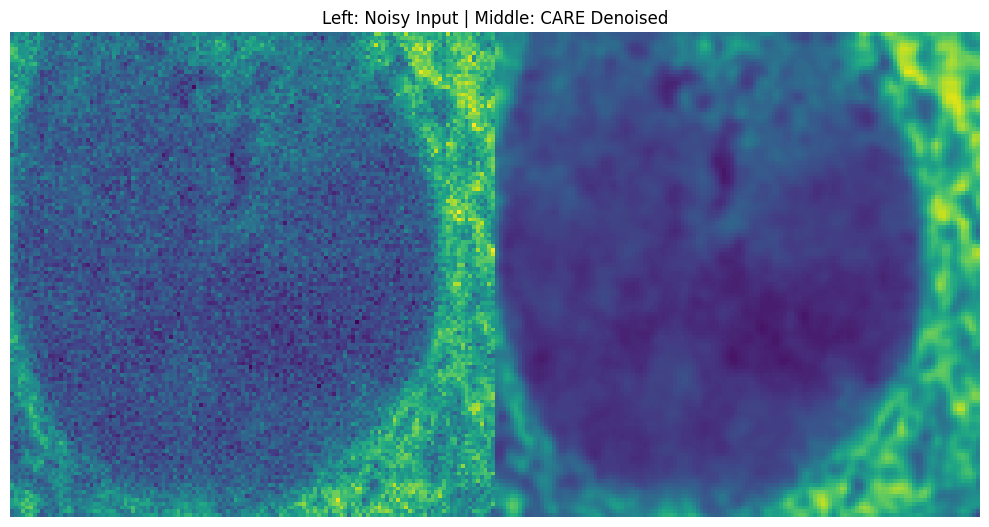

In [25]:
# Create a side-by-side comparison image
x_start, y_start = 50, 50  # Define crop region
size = 128

# Normalize images for visualization
norm_noisy = (test_noisy_slice - test_noisy_slice.min()) / (test_noisy_slice.max() - test_noisy_slice.min())
norm_denoised = (denoised_images - denoised_images.min()) / (denoised_images.max() - denoised_images.min())

# Crop regions and concatenate 
noisy_crop = norm_noisy[y_start:y_start+size, x_start:x_start+size]
denoised_crop = norm_denoised[y_start:y_start+size, x_start:x_start+size]
comparison = np.concatenate([noisy_crop, denoised_crop], axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(comparison, cmap="viridis")
plt.title("Left: Noisy Input | Middle: CARE Denoised")
plt.axis('off')
plt.tight_layout()
plt.savefig("Microsim_CARE_comparison.jpg", dpi=300, bbox_inches='tight')
plt.show()

## And you're done! Now we can export the model to BMZ format

In [26]:
# Define description for the model
general_description = """
This model is trained using the CARE (Content-Aware Image Restoration) algorithm to denoise 
synthetic microscopy images generated with Microsim. The images simulate cellular structures 
resembling nuclear envelope, endoplasmic reticulum, and mitochondrial membranes labeled 
with various fluorophores and imaged using confocal fluorescence microscopy.

CARE is a supervised denoising method that learns to map from noisy images to clean images 
using paired training data. Unlike self-supervised methods, CARE requires ground truth 
clean images during training but typically achieves superior denoising performance.

The model was trained on multiple noise realizations with varying exposure times, 
read noise levels, and detector gains to ensure robust performance across different 
imaging conditions.
"""

# Export the model
careamist.export_to_bmz(
    path_to_archive="microsim_care_model.zip",
    friendly_model_name="Microsim_CARE",
    input_array=test_noisy_slice.astype(np.float32),  # Use 2D slice as example input
    authors=[{"name": "CAREamics authors", "affiliation": "Human Technopole"}],
    general_description=general_description,
    data_description="Synthetic confocal fluorescence microscopy data of cellular structures "
                     "simulated with Microsim. Training data includes paired noisy/clean images "
                     "with realistic detector noise characteristics."
)

print("CARE model successfully exported to microsim_care_model.zip")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.81it/s]


[10:24:13:501679] WARNING  Your CAREamics version seems to be a locally modified version              ]8;id=553121;file:///home/diya.srivastava/Desktop/careamics/src/careamics/utils/version.py\version.py]8;;\:]8;id=335457;file:///home/diya.srivastava/Desktop/careamics/src/careamics/utils/version.py#29\29]8;;\
                           (0.0.12.dev13+gce27d0d). The recorded version for loading models will be                
                           0.0.12, which may not exist. If you want to ensure exporting the model                  
                           with an existing version, please install the closest CAREamics version                  
                           from PyPI or conda-forge.                                                               

[10:24:13:505176] WARNING  Your CAREamics version seems to be a locally modified version              ]8;id=184155;file:///home/diya.srivastava/Desktop/careamics/src/careamics/utils/version.py\version.py]8;;\:]8;id=129523;file:///home/diya.srivastava/Desktop/careamics/src/careamics/utils/version.py#29\29]8;;\
                           (0.0.12.dev13+gce27d0d). The recorded version for loading models will be                
                           0.0.12, which may not exist. If you want to ensure exporting the model                  
                           with an existing version, please install the closest CAREamics version                  
                           from PyPI or conda-forge.                                                               

computing SHA256 of inputs.npy (result: c04be1f572fa77daa14dc03d1a9af7236d73b3195bc90cf76bd8127f80b7ba06): 100%|██████████| 262272/262272 [00:00<00:00, 297712719.54it/s]
computing SHA256 of outputs.npy (result: de82a184165e70351745ac2af113aa9b52ea35dc23a8cdcbba93f99cde3f83c5): 100%|██████████| 262272/262272 [00:00<00:00, 332340936.16it/s]
computing SHA256 of environment.yml (result: bbf164cd3dd96acb2abdceede0c319cf29488ba6d51d34fae21d44c31f65d76a): 100%|██████████| 131/131 [00:00<00:00, 276802.93it/s] 
computing SHA256 of weights.pth (result: e32bcf671b1bcbd4e8411258df5120eaeb48023348d3d3577d21917a544202c4): 100%|██████████| 2066750/2066750 [00:00<00:00, 945319279.39it/s] 
computing SHA256 of careamics.yaml (result: b5cbf62ed6bb968c217ac3994c3138e954ecbf1ae6077b4fb9ff3a5c76715f31): 100%|██████████| 1259/1259 [00:00<00:00, 2285986.47it/s] 
2025-09-23 10:24:13.562 | Level 30 | bioimageio.spec._internal.field_warning:wrapper:78 - Description longer than 512 characters.
2025-09-23 10:24:13

CARE model successfully exported to microsim_care_model.zip
